# RFClassifier_final

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import lightgbm_with_simple_features as lgbmsf
import json
import seaborn as sns
import re
import missingno as msno
import numpy as np
import matplotlib.pyplot as plt

#from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

from imputer_selection import imputer_selection

with open('config.json', 'r') as f:
    config = json.load(f)
    
NUM_ROWS = config["NUM_ROWS"]

# But de notebook

On cherche ici à modéliser la probabilité qu'une personne rembourse ou non un emprunt contracté auprès de l'institution HomeCredit à partir d'une large base de données de ses clients.\
Conformément aux instructions, on ne cherchera pas ici à réaliser le _feature engineering_ de zéro, mais on se servira au contraire du kernel Lightgbm_with_simple_features. Ce kernel permet en principe de réaliser toute la chaîne de modélisation et de prédiction, mais nous ne réutiliserons ici que la partie _feature engineering_, qu'on va chercher à compléter ici de manière à appliquer d'autres modèles que celui proposé dans le kernel (LightGBM).

**[I. Exploration des datasets](#I.-Exploration-des-datasets)**
* [I.1 application_train.csv](#I.1-application_train.csv)

# I. Exploration des datasets

Dans cette partie on explore les différents datasets. Dans la mesure où la mission ici est centrée sur le déploiement du modèle via une api et non sur la construction du modèle lui-même, on se reportera au kernel fourni dans les ressources du projet, et on ré-utilisera le feature engineering réalisé dans ce kernel. On se contentera d'analyser les features créées - statistiques univariées, corrélations via les statistiques bivariées, valeurs manquantes, possibilité de retirer des colonnes/imputer et finalement feature importance.

## I.1 application_train.csv

Chargement de la table et application du _feature engineering_ par application de la fonction application_train_test du kernel lightgbm_sf 

In [2]:
application_train_df = pd.read_csv('./data/application_train.csv')
application_train_df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


**Observations**

- les variables _DAYS_EMPLOYED_, _DAYS_BIRTH_, _DAYS_ID_PUBLISH_ sont négatives

In [4]:
application_train_df['DAYS_BIRTH'].head()

0     9461
1    16765
2    19046
3    19005
4    19932
Name: DAYS_BIRTH, dtype: int64

**La fonction application_train_test du module lgbm_sf**

In [5]:
train_df_processed = lgbmsf.application_train_test(num_rows=NUM_ROWS)
train_df_processed.head()

Train samples: 15000


,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
0,100002,1,0,0,0,0,202500.0,406597.5,24700.5,351000.0,...,0,1,0,1,0,0.067329,0.498036,202500.0,0.121978,0.060749
1,100003,0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,...,0,0,0,1,0,0.070862,0.208736,135000.0,0.132217,0.027598
2,100004,0,0,1,0,0,67500.0,135000.0,6750.0,135000.0,...,0,0,0,0,0,0.011814,0.500000,67500.0,0.100000,0.050000
3,100006,0,1,0,0,0,135000.0,312682.5,29686.5,297000.0,...,0,0,0,0,0,0.159905,0.431748,67500.0,0.219900,0.094941
4,100007,0,0,0,0,0,121500.0,513000.0,21865.5,513000.0,...,0,0,0,0,0,0.152418,0.236842,121500.0,0.179963,0.042623


In [7]:
for col in ['DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH']:
    train_df_processed[col] = np.abs(train_df_processed[col])

Inspection des corrélations des nouvelles variables

<AxesSubplot:>

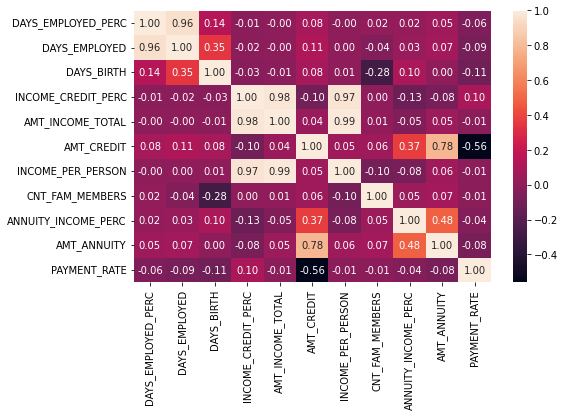

In [9]:
corr = train_df_processed[['DAYS_EMPLOYED_PERC', 'DAYS_EMPLOYED', 'DAYS_BIRTH', 'INCOME_CREDIT_PERC', 
                   'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'INCOME_PER_PERSON', 'CNT_FAM_MEMBERS', 
                   'ANNUITY_INCOME_PERC', 'AMT_ANNUITY', 'PAYMENT_RATE']].corr()

fig, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(corr, annot=True, fmt='.2f')

In [10]:
train_df_processed.drop(columns=['DAYS_EMPLOYED','AMT_INCOME_TOTAL', 'INCOME_PER_PERSON'], inplace=True)

Certaines colonnes n'ont pas de corrélations définies avec TARGET. Cela indique que ces colonnes n'ont qu'une valeur: elles sont donc inutiles pour la prédiction

In [11]:
corr = train_df_processed.corr()
corr.loc[corr['TARGET'].isna(), "TARGET"]

FLAG_MOBIL         NaN
FLAG_DOCUMENT_2    NaN
FLAG_DOCUMENT_10   NaN
FLAG_DOCUMENT_12   NaN
Name: TARGET, dtype: float64

In [12]:
flag_cols = corr.loc[corr['TARGET'].isna(), "TARGET"].index
train_df_processed.drop(columns=flag_cols, inplace=True)

Enfin, on se débarasse des colonnes comportant trop de valeurs manquantes (plus de 75% des données)

In [13]:
ratio_nna = train_df_processed.notna().sum()/train_df_processed.shape[0]
to_drop = ratio_nna[ratio_nna<0.75].index
train_df_processed.drop(columns=to_drop, inplace=True)

Pour les colonnes restantes, on réalise une imputation par la moyenne

In [14]:
train_df_processed.fillna(train_df_processed.mean(), inplace=True)

En vue de la réalisation des prédictions, on standardise les variables qui ne sont pas des variables encodées 'one-hot', c'est-à-dire les variables dont le type n'est pas 'uint8'

In [15]:
uint_cols = [col for col in train_df_processed.columns if train_df_processed[col].dtype=='uint8']

In [16]:
cols_to_scale = [col for col in train_df_processed.columns if (col not in uint_cols) & (col!='SK_ID_CURR')]
scaler = StandardScaler()
train_df_processed[cols_to_scale] = scaler.fit_transform(train_df_processed[cols_to_scale])

In [17]:
train_df_processed.head()

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,ANNUITY_INCOME_PERC,PAYMENT_RATE
0,100002,3.431739,-1.383999,-0.714225,-0.661103,-0.58016,-0.482152,-0.166301,-0.511023,-0.141322,...,0,0,1,0,1,0,-0.739199,0.049914,-0.623541,0.325578
1,100003,-0.291397,0.722544,-0.714225,1.512624,-0.58016,1.713327,0.594894,1.584249,-1.247741,...,0,0,0,0,1,0,-0.710140,-0.117433,-0.516658,-1.158706
2,100004,-0.291397,-1.383999,1.400118,-0.661103,-0.58016,-1.154475,-1.408694,-1.092370,-0.777114,...,0,0,0,0,0,0,-1.195829,0.051050,-0.852964,-0.155705
3,100006,-0.291397,0.722544,-0.714225,-0.661103,-0.58016,-0.714632,0.178791,-0.656360,-0.923066,...,0,0,0,0,0,0,0.022264,0.011569,0.398657,1.856477
4,100007,-0.291397,-1.383999,-0.714225,-0.661103,-0.58016,-0.218759,-0.362518,-0.075013,0.573717,...,0,0,0,0,0,0,-0.039319,-0.101174,-0.018241,-0.486007
